Import packages

In [27]:
from collections import Counter
import math
import os

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyradiobiology import LKB
from pyradiobiology.primitives import Dose, DoseType, DoseBag
import scipy as sp
from scipy import signal
from scipy import stats

To install packages

In [ ]:
# import sys
# %conda install --yes --prefix {sys.prefix} scipy

# Apparently this package requires pip
# %pip install pyradiobiology

Set global variables

In [102]:
# PROJECT_DATA = os.path.join('jolien', 'Anonymized_planned_vs_delivered_dose_accumulation_data')
# INPUT_DIR = os.path.join('input_data', PROJECT_DATA)
INPUT_DIR = 'Anonymized_planned_vs_delivered_dose_accumulation_data'

ADAPTED_PATIENTS = [
    'a12d277b',
    'a6cecdc7',
    '0f21acd5',
    'c85c425b',
    '9b6b2bfa',
    '584a5f6f',
    '7a2278da',
    '65079eb2',
    '18a10b59',
    '80b18507',
    '5637a8a5',
    '4165ec7b',
    '3b0c9681',
    '6051d40d',
    'd87618b0',
    '152f067b',
    '2dfb48cd',
    '06bd9ded',
    '471c7d66',
    '9bf04b57',
    'a5495951',
    'b861a48f',
    'e19eaf8c',
    '8da2af5c',
    '113c1741'
]

JOLIEN_52_PATIENTS = [
    'a12d277b',
    '201f060a',
    '31c6b8d5',
    '3915799f',
    'e32e1305',
    'bc13da51',
    'f9e5560a',
    'c6293de3',
    'f7067398',
    'e4229483',
    'efe3982f',
    'a398bdd2',
    '3c0606a7',
    '2e33a8ad',
    '9ef3cb1b',
    '0f21acd5',
    '7282758',
    '76ec4dea',
    'e847c8ca',
    '60372aa9',
    '7880afe2',
    'c85c425b',
    '08de11ea',
    'e89a311a',
    'bd33c435',
    '056aea4e',
    '0c51fd88',
    '7a2278da',
    '166493de',
    '2a07099e',
    '7c585a17',
    '65079eb2',
    '59502baa',
    '18a10b59',
    'd0b2d3fc',
    '05b340b2',
    '73f7595e',
    '3502872b',
    '80b18507',
    '3b53be84',
    '2d67c27f',
    '4165ec7b',
    '6051d40d',
    '6ab636a3',
    '152f067b',
    '471c7d66',
    '4d999226',
    '9bf04b57',
    'f8a1cef0',
    'b861a48f',
    'e19eaf8c',
    '8da2af5c'
]

ADAPTED_PATIENTS_NOT_IN_JOLIEN_PATIENTS = [
    '113c1741', '5637a8a5', 'a6cecdc7', '2dfb48cd', '9b6b2bfa', '3b0c9681', 'd87618b0', 'a5495951', '584a5f6f', '06bd9ded'
]

JOLIEN_PATIENTS_FOLDER_MISSING = [
    '7282758'
]

JOLIEN_PATIENTS_WITH_DATA = [
    'a12d277b',
    '201f060a',
    '31c6b8d5',
    '3915799f',
    'e32e1305',
    'bc13da51',
    'f9e5560a',
    'c6293de3',
    'f7067398',
    'e4229483',
    'efe3982f',
    'a398bdd2',
    '3c0606a7',
    '2e33a8ad',
    '9ef3cb1b',
    '0f21acd5',
    '76ec4dea',
    'e847c8ca',
    '60372aa9',
    '7880afe2',
    'c85c425b',
    '08de11ea',
    'e89a311a',
    'bd33c435',
    '056aea4e',
    '0c51fd88',
    '7a2278da',
    '166493de',
    '2a07099e',
    '7c585a17',
    '65079eb2',
    '59502baa',
    '18a10b59',
    'd0b2d3fc',
    '05b340b2',
    '73f7595e',
    '3502872b',
    '80b18507',
    '3b53be84',
    '2d67c27f',
    '4165ec7b',
    '6051d40d',
    '6ab636a3',
    '152f067b',
    '471c7d66',
    '4d999226',
    '9bf04b57',
    'f8a1cef0',
    'b861a48f',
    'e19eaf8c',
    '8da2af5c'
]

In [59]:
# set(ADAPTED_PATIENTS).issubset(set(ALL_PATIENTS))
adapt_not_in_52 = set(ADAPTED_PATIENTS).difference(set(JOLIEN_52_PATIENTS))
print(adapt_not_in_52) # {'113c1741', '5637a8a5', 'a6cecdc7', '2dfb48cd', '9b6b2bfa', '3b0c9681', 'd87618b0', 'a5495951', '584a5f6f', '06bd9ded'}

{'113c1741', '5637a8a5', 'a6cecdc7', '2dfb48cd', '9b6b2bfa', '3b0c9681', 'd87618b0', 'a5495951', '584a5f6f', '06bd9ded'}


In [60]:
all_patients_dir = os.listdir(INPUT_DIR)
all_patients_dir = [f for f in all_patients_dir if f[0] != '.'] # ignore hidden files/directories
set(JOLIEN_52_PATIENTS).issubset(set(all_patients_dir))
patients_not_in_dir = set(JOLIEN_52_PATIENTS).difference(set(all_patients_dir))
print(patients_not_in_dir) # {'7282758'}

{'7282758'}


## Define NTCP Models

In [29]:
def calculate_NTCP_LKB(doses, volumes, td50, m, n, ab_ratio, nfx):
    """
    Calculate the NTCP for a given patient using the Lyman-Kutcher-Burman (LKB) model.

    Parameters
    ----------
    doses : np.array[float]
        The dDVH doses in Gy.
    volumes : np.array[float]
        The dDVH volumes for each dose in cc.
    td50 : float
        The uniform dose to the whole organ resulting in 50% complication probability.
    m : float
        The slope of the NTCP curve.
    n : float
        The volume dependency parameter (n = 1 is the mean dose model).
    ab_ratio : float
        The a/B ratio of the tissue of interest.
    nfx : int
        The number of fractions for the treatment.
    verbose : bool, optional
        Whether to print the computed results (`True`) or not (`False`).

    Returns
    -------
    NTCPs : np.array[float]
        The predicted NTCP using the LKB method.

    """
    # From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
    #   td50 = 39.9 Gy
    #   m = 0.4
    #   n = 1 (mean dose)
    # Other:
    #   a/B = 3
    lkb_model = LKB(td50=Dose.gy(td50, dose_type=DoseType.EQD2), m=m, n=n)
    NTCP = 100 * lkb_model.response_from_pysical_dose(
        dose_array_in_physical_dose = DoseBag.create(data=doses, dose_type=DoseType.PHYSICAL_DOSE),
        volume_array = volumes,
        ab_ratio = Dose.gy(ab_ratio),
        nfx = nfx
    )
    return NTCP

# def calculate_NTCP_Lee(mean_ipsalateral_parotid_dose, mean_contralateral_parotid_dose):
    # For the 3-month time point: S = −32.29 + (Dmean-c*0.637) + (Dmean-i*0.185) + (age*0.202)
    # For the 12-month time point: S = −44.87+ (Dmean-c*1.400) + (Dmean-i*0.358) + (T stage*corresponding coefficient);

def calculate_NTCP_Beetz(mean_contralateral_parotid_dose, baseline_xerostomia_score):
    """
    Calculate the NTCP for a given patient using the Beetz et al., 2012 paper.

    Parameters
    ----------
    mean_contralateral_parotid_dose : np.ndarray
        The mean dose to the contralateral parotid gland.
    baseline_xerostomia_score : np.ndarray
        The baseline xerostomia score (on a 4-point scale, I believe).
    verbose : bool, optional
        Whether to print the computed results (`True`) or not (`False`).

    Returns
    -------
    NTCP : float
        The predicted NTCP using the Beetz method.

    """
    S = -1.443 + (mean_contralateral_parotid_dose * 0.047) + (baseline_xerostomia_score * 0.720)
    NTCP = 100 * (1 + math.exp(-S))**(-1)
    return NTCP

## NTCP Plot Example

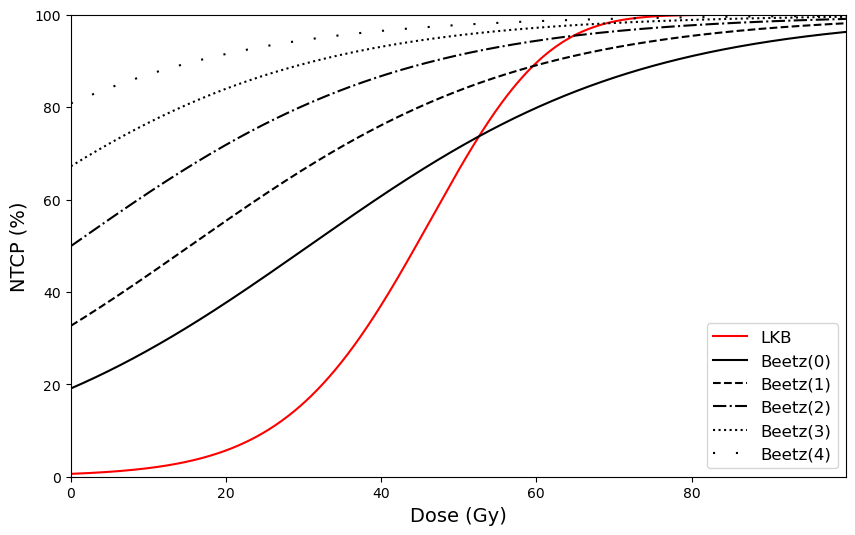

In [30]:
# Fake dose data
doses = np.arange(0,100,0.1)

all_linestyles = ['-','--','-.',':',(0,(1,10))]
plt.figure(figsize=(10,6))
# LKB
all_NTCPs_LKB = [calculate_NTCP_LKB([d], [1], 39.9, 0.4, 1, 3, 30) for d in doses]
plt.plot(doses, all_NTCPs_LKB, color='r', label='LKB')
# Beetz
for i,baseline_xerostomia_score in enumerate([0,1,2,3,4]):
    baseline_xerostomia_scores = baseline_xerostomia_score * np.ones(len(doses))
    all_NTCPs = [calculate_NTCP_Beetz(d,s) for d,s in zip(doses, baseline_xerostomia_scores)]
    plt.plot(doses, all_NTCPs, color='k', linestyle=all_linestyles[i], label=f'Beetz({baseline_xerostomia_score})')

plt.xlabel('Dose (Gy)', fontsize=14)
plt.ylabel('NTCP (%)', fontsize=14)
plt.xlim([0,max(doses)])
plt.ylim([0,100])
plt.legend(fontsize=12)
plt.show()

## Accumulate DVHs

In [32]:
def convolve_DVHs(total_dose, fx_dose):
    conv_dose = np.convolve(fx_dose, total_dose, mode='full')[0:len(fx_dose)]
    cumsum_conv = np.cumsum(conv_dose[::-1])[::-1]
    plot_conv_dose = (cumsum_conv - np.min(cumsum_conv)) / (np.max(cumsum_conv) - np.min(cumsum_conv))
    new_total_dose = -np.diff(plot_conv_dose)
    return plot_conv_dose, new_total_dose

def compute_dose_at_fx(total_dose, fx_dose, current_fx, final_fx):
    new_total_dose = total_dose
    remaining_fx = final_fx - current_fx
    for _ in range(remaining_fx):
        plot_conv_dose, new_total_dose = convolve_DVHs(new_total_dose, fx_dose)
        # conv_dose = np.convolve(fx_dose, total_dose, mode='full')[0:len(fx_dose)]
        # cumsum_conv = np.cumsum(conv_dose[::-1])[::-1]
        # plot_conv_dose = (cumsum_conv - np.min(cumsum_conv)) / (np.max(cumsum_conv) - np.min(cumsum_conv))
        # total_dose = -np.diff(plot_conv_dose)
        # # plt.plot(x, plot_conv_dose, label=f'Predicted Dose fx: {current_fx+i+1}')
    return plot_conv_dose, new_total_dose

Test functions on dummy data

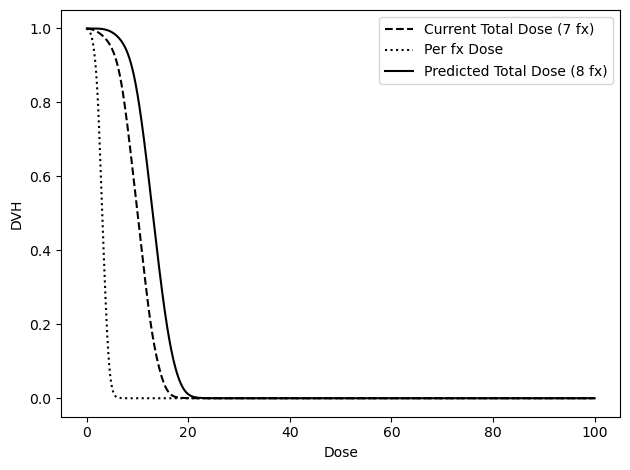

In [33]:
current_fx = 7
final_fx = 8
d1 = np.random.normal(3,1,1000)
x = np.linspace(0, 100, 1000)
total_dose = sp.stats.gaussian_kde(np.array(np.random.normal(10,3,1000)))(x)
fx_dose = sp.stats.gaussian_kde(np.array(d1))(x)

plt.figure()
cumsum_total_dose = np.cumsum(total_dose[::-1])[::-1]
cumsum_fx_dose = np.cumsum(fx_dose[::-1])[::-1]
plot_total_dose = (cumsum_total_dose-np.min(cumsum_total_dose))/(np.max(cumsum_total_dose)-np.min(cumsum_total_dose))
plot_fx_dose = (cumsum_fx_dose-np.min(cumsum_fx_dose))/(np.max(cumsum_fx_dose)-np.min(cumsum_fx_dose))
plt.plot(x, plot_total_dose, color='k', linestyle='--', label=f'Current Total Dose ({current_fx} fx)')
plt.plot(x, plot_fx_dose, color='k', linestyle=':', label='Per fx Dose')
predicted_total_dose,_ = compute_dose_at_fx(total_dose, fx_dose, current_fx, final_fx)
plt.plot(x, predicted_total_dose, color='k', label=f'Predicted Total Dose ({final_fx} fx)')


# plt.plot(x, nconv, color='k', label='Actual Accumulated Dose')
plt.xlabel('Dose')
plt.ylabel('DVH')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## Compute planned and delivered dose and NTCP for a patient

In [77]:
patient = '0c51fd88' # right parotid
patient = 'a12d277b'  # R parotid
# dose_type = 'fx'
group_name = 'Original' # Planned dose = 'Original'; Delivered dose = 'RTS'
left_parotid_name = 'left parotid'
right_parotid_name = 'right parotid'
# From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
td50 = 39.9     # Gy
m = 0.4
n = 1           # Mean dose if n = 1
# Other:
aB_ratio = 3

# dDVHs = [] # not used

# Grab all dvh files (fx and accumulated dose)
# Assumes the folder doesn't contain the csv files yet
all_fx_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' in f]
all_accum_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' not in f]
assert len(all_accum_files) == len(all_fx_files)
nfx = len(all_fx_files)
# # Grab all dvh files (fx and accumulated dose) with .csv extension
all_fx_files = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
all_accum_files = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]

# Is this 10 a specific fraction?
# df_fx = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_fx_files[10]))
fx_no = 10
df_fx = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))
# Get only the desired structures
print("Fx column index ", np.where(df_fx.columns == right_parotid_name)[0][0]+1)
vol_ind_fx = np.where(df_fx.columns == right_parotid_name)[0][0]+1
# vol_col_fx = df_fx.columns[vol_ind_fx]
# vol_fx = float(vol_col_fx)
dvh_fx = df_fx[right_parotid_name]
dose_fx = np.array(dvh_fx/100) # because it is given in cGy?
vol_percent_fx = np.array(df_fx.iloc[:,vol_ind_fx])
# dDVH
dDVH_dose_fx = dose_fx[~np.isnan(dose_fx)][:-1]
dDVH_vol_percent_fx = -np.diff(vol_percent_fx)
dDVH_vol_percent_fx = dDVH_vol_percent_fx[~np.isnan(dDVH_vol_percent_fx)] # keep non-NaN values
# NTCP
NTCP_fx = calculate_NTCP_LKB(dDVH_dose_fx, dDVH_vol_percent_fx, td50, m, n, aB_ratio, 1)
print(f'NTCP fx {fx_no} = {NTCP_fx:.2f}%')

# Predict the dose at the final fx
# df_accum = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_accum_files[10]))
fx_no = 10
df_accum = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_accum_files[fx_no]))
# Get only the desired structures
vol_ind_accum = np.where(df_accum.columns == right_parotid_name)[0][0]+1
print("Accum column index ", np.where(df_fx.columns == right_parotid_name)[0][0]+1)
# vol_col_accum = df_accum.columns[vol_ind_accum]
# vol_accum = float(vol_col_accum)
dvh_accum = df_accum[right_parotid_name]
dose_accum = np.array(dvh_accum/100) # because it is given in cGy?
vol_percent_accum = np.array(df_accum.iloc[:,vol_ind_accum])
# dDVH
dDVH_dose_accum = dose_accum[~np.isnan(dose_accum)][:-1]
dDVH_vol_percent_accum = -np.diff(vol_percent_accum)
dDVH_vol_percent_accum = dDVH_vol_percent_accum[~np.isnan(dDVH_vol_percent_accum)] # keep non-NaN values

plt.figure(figsize=(6,6))
plt.plot(dose_fx, 100*vol_percent_fx, 'r', label=f'Per fx Dose Fx {fx_no}')
plt.plot(dose_accum, 100*vol_percent_accum, 'k', label=f'Accum Dose Fx {fx_no}')
plt.legend()
plt.xlabel('Dose (Gy)')
plt.ylabel('Percentage (%)')
plt.title(f'{group_name} Dose')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(dDVH_dose_fx, 100*dDVH_vol_percent_fx, 'r', label=f'Per fx Dose Fx {fx_no}')
plt.plot(dDVH_dose_accum, 100*dDVH_vol_percent_accum, 'k', label=f'Accum Dose Fx {fx_no}')
plt.legend()
plt.xlabel('Dose (Gy)')
plt.ylabel('Percentage (%)')
plt.title(f'{group_name} Dose')
plt.show()

x = np.arange(0, 30, 0.1)
current_fx = 10
final_fx = 15
vol_percent_accum = np.pad(vol_percent_accum, (0,len(x)-len(vol_percent_accum)), 'constant') # add 0's to fit in graph?
vol_percent_fx = np.pad(vol_percent_fx, (0,len(x)-len(vol_percent_fx)), 'constant')
plt.plot(x, 100*vol_percent_accum, color='k', linestyle='--', label=f'Current Total Dose ({current_fx} fx)')
plt.plot(x, 100*vol_percent_fx, color='k', linestyle=':', label='Per fx Dose')
dDVH_vol_percent_accum_padded = np.pad(dDVH_vol_percent_accum, (0,len(x)-len(dDVH_vol_percent_accum)), 'constant')
dDVH_vol_percent_fx_padded = np.pad(dDVH_vol_percent_fx, (0,len(x)-len(dDVH_vol_percent_fx)), 'constant')
# compute_dose_at_fx(total_dose, fx_dose, current_fx, final_fx)
vol_percent_predicted,_ = compute_dose_at_fx(dDVH_vol_percent_accum_padded, dDVH_vol_percent_fx_padded, current_fx, final_fx)
plt.plot(x, 100*vol_percent_predicted, color='k', label=f'Predicted Total Dose ({final_fx} fx)')
plt.legend()
plt.xlabel('Dose (Gy)')
plt.ylabel('Perecentage (%)')
plt.title(f'{group_name} Dose')
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

## Compute planned and delivered doses and NTCPs for all patients

Code to test values

In [66]:
all_patients = os.listdir(INPUT_DIR)
all_patients = [f for f in all_patients if f[0] != '.'] # ignore hidden files/directories
print(all_patients)
print(len(all_patients))
groups = ['Original', 'RTS']

# nonempty_patients = {}
nfxs = []
for patient in JOLIEN_PATIENTS_WITH_DATA: # all_patients:
    for group_name in groups:
        # Grab all dvh files (fx and accumulated dose)
        # Assumes the folder doesn't contain the csv files yet
        all_fx_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' in f]
        all_accum_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' not in f]
        # print(all_fx_files)
        assert len(all_accum_files) == len(all_fx_files)
        nfx = len(all_fx_files)
        # if nfx > 0:
        #     nonempty_patients[patient] = nfx
        #     nfxs.append(nfx)
        # nonempty_patients[patient] = nfx
        nfxs.append(nfx)
        # # Grab all dvh files (fx and accumulated dose) with .csv extension
        all_fx_files_2 = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
        # print(all_fx_files_2)
        all_accum_files_2 = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
        assert sorted(all_fx_files_2) == sorted(all_fx_files)
        assert sorted(all_accum_files_2) == sorted(all_accum_files_2)
# Fileanames are the same but those with _2 suffix are in order

np.min(nfxs) # 30
# np.max(nfxs) # 36

['80b18507', 'cfbfe1d3', 'f7067398', '59502baa', '133e5e14', '3915799f', '6051d40d', '584a5f6f', '08de11ea', 'd0b2d3fc', '201f060a', '7ee6b2e5', '60372aa9', 'c6293de3', '79a04919', 'a398bdd2', '1674addf', '0c51fd88', 'e65a507d', 'e32e1305', '2afc5ebb', 'b861a48f', 'f9e5560a', '9ef3cb1b', '8da2af5c', '0f21acd5', '056aea4e', '06bd9ded', '3c0606a7', '31c6b8d5', '5637a8a5', 'bd33c435', 'a6cecdc7', '65079eb2', '6ab636a3', '3b0c9681', 'eaf5a9c5', '73f7595e', '568864b2', 'e847c8ca', 'e4229483', '2e33a8ad', 'aa01f821', '3b53be84', '113c1741', '1dcf9322', '4165ec7b', '166493de', '9b6b2bfa', '2a07099e', 'd17a1b80', '7a2278da', '53d7cd25', '55be1518', '7880afe2', 'ec1df3f8', '2d67c27f', 'e19eaf8c', '18a10b59', 'c85c425b', '152f067b', 'efe3982f', '9bf04b57', 'bc13da51', 'f0833b26', '4d999226', 'f8a1cef0', 'd87618b0', 'e89a311a', 'dfd406ca', '2d706997', 'a12d277b', '471c7d66', '97923493', '05b340b2', 'a5495951', '7c585a17', '2dfb48cd', '76ec4dea', '3502872b', 'e8df0fa8', '07282758', 'f9b6fb02']
83


30

### Compute NTCPs from 'Anonymized_planned_vs_delivered_dose_accumulation_data'

In [132]:
all_patients = os.listdir(INPUT_DIR)
all_patients = [f for f in all_patients if f[0] != '.'] # ignore hidden files/directories
groups = ['Original', 'RTS']
left_parotid_name = 'left parotid'
right_parotid_name = 'right parotid'
# From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
td50 = 39.9     # Gy
m = 0.4
n = 1           # Mean dose if n = 1
# Other:
aB_ratio = 3
max_no_fx = 36

patients_missing_parotid = ['60372aa9', '166493de','65079eb2','59502baa','4d999226']
# patients_checked = ['a12d277b', '201f060a', '31c6b8d5', '3915799f', 'e32e1305', 'bc13da51', 'f9e5560a', 'c6293de3', 'f7067398', 'e4229483', 'efe3982f', 'a398bdd2', '3c0606a7', '2e33a8ad', '9ef3cb1b', '0f21acd5', '76ec4dea', 'e847c8ca', '7880afe2', 'c85c425b', '08de11ea', 'e89a311a', 'bd33c435', '056aea4e', '0c51fd88', '7a2278da', '2a07099e', '7c585a17', '18a10b59', 'd0b2d3fc', '05b340b2', '73f7595e', '3502872b', '80b18507', '3b53be84', '2d67c27f', '4165ec7b', '6051d40d', '6ab636a3', '152f067b', '471c7d66', '9bf04b57', 'f8a1cef0', 'b861a48f', 'e19eaf8c', '8da2af5c']
patients_checked = []
all_patient_NTCPs = {}
for patient in JOLIEN_PATIENTS_WITH_DATA: # all_patients:
    if patient in patients_missing_parotid: # or patient in patients_checked:
        continue
    print(patient)
    patient_NTCPs = {}
    for group_name in groups:
        print("\t", group_name)
        # Grab all dvh files (fx and accumulated dose)
        # Assumes the folder doesn't contain the csv files yet
        all_fx_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' in f]
        all_accum_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' not in f]
        assert len(all_accum_files) == len(all_fx_files)
        nfx = len(all_fx_files)
        # # Grab all dvh files (fx and accumulated dose) with .csv extension (they are the same in this case)
        all_fx_files = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
        all_accum_files = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]

        NTCPs = []
        for fx_no in range(nfx):
            # print("\t\t", fx_no)
            # filename = os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no])
            # print("\t\t", filename)
            df_fx = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))

            parotid_names = [
                right_parotid_name,
                'R parotid',
                'Rt parotid',
                'parotid_r',
                'RParotid',
                '6b Rt Parotid',
                'R Parotid',
                'Parotid rt',
                'Rt Parotid -15',
                'Rt Parotid',
                'Right parotid',
                'R PAROTID',
                'RT parotid',
                'rt parotid',
                'RT PAROTID'
            ]
            parotid_found = False
            for name in parotid_names:
                if np.any(np.where(df_fx.columns == name)[0]): # if list not empty
                    actual_right_parotid_name = name
                    parotid_found = True
                    break

            if not parotid_found:
                print(f"\t\tFx {fx_no+1}. Right parotid column name not found.")
                print("\t\t", os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))
            
            # Get only the desired structures
            # vol_ind_fx = np.where(df_fx.columns == right_parotid_name)[0][0]+1
            vol_ind_fx = np.where(df_fx.columns == actual_right_parotid_name)[0][0]+1
            # vol_col_fx = df_fx.columns[vol_ind_fx]
            # vol_fx = float(vol_col_fx)
            # dvh_fx = df_fx[right_parotid_name]
            dvh_fx = df_fx[actual_right_parotid_name]
            dose_fx = np.array(dvh_fx/100) # because it is given in cGy?
            vol_percent_fx = np.array(df_fx.iloc[:,vol_ind_fx])
            # dDVH
            dDVH_dose_fx = dose_fx[~np.isnan(dose_fx)][:-1]
            dDVH_vol_percent_fx = -np.diff(vol_percent_fx)
            dDVH_vol_percent_fx = dDVH_vol_percent_fx[~np.isnan(dDVH_vol_percent_fx)] # keep non-NaN values
            # NTCP
            NTCP_fx = calculate_NTCP_LKB(dDVH_dose_fx, dDVH_vol_percent_fx, td50, m, n, aB_ratio, 1)
            # print(f'{group_name} NTCP fx {fx_no} = {NTCP_fx:.2f}%')
            NTCPs.append(NTCP_fx)
        
        # Requires fractions to be in order
        patient_NTCPs[f"{group_name}"] = NTCPs

    patients_checked.append(patient)
    # print(patients_checked)
    patient_NTCPs["Diffs"] = [a_i - b_i for a_i, b_i in zip(patient_NTCPs['RTS'], patient_NTCPs['Original'])]
    # patient_NTCPs["Diffs"] = np.subtract(patient_NTCPs['RTS'], patient_NTCPs['Original']).tolist()
    all_patient_NTCPs[patient] = patient_NTCPs
    # print(patient_NTCPs, "\n")

a12d277b
	 Original
	 RTS
201f060a
	 Original
	 RTS
31c6b8d5
	 Original
	 RTS
3915799f
	 Original
	 RTS
e32e1305
	 Original
	 RTS
bc13da51
	 Original
	 RTS
f9e5560a
	 Original
	 RTS
c6293de3
	 Original
	 RTS
f7067398
	 Original
	 RTS
e4229483
	 Original
	 RTS
efe3982f
	 Original
	 RTS
a398bdd2
	 Original
	 RTS
3c0606a7
	 Original
	 RTS
2e33a8ad
	 Original
	 RTS
9ef3cb1b
	 Original
	 RTS
0f21acd5
	 Original
	 RTS
76ec4dea
	 Original
	 RTS
e847c8ca
	 Original
	 RTS
7880afe2
	 Original
	 RTS
c85c425b
	 Original
	 RTS
08de11ea
	 Original
	 RTS
e89a311a
	 Original
	 RTS
bd33c435
	 Original
	 RTS
056aea4e
	 Original
	 RTS
0c51fd88
	 Original
	 RTS
7a2278da
	 Original
	 RTS
2a07099e
	 Original
	 RTS
7c585a17
	 Original
	 RTS
18a10b59
	 Original
	 RTS
d0b2d3fc
	 Original
	 RTS
05b340b2
	 Original
	 RTS
73f7595e
	 Original
	 RTS
3502872b
	 Original
	 RTS
80b18507
	 Original
	 RTS
3b53be84
	 Original
	 RTS
2d67c27f
	 Original
	 RTS
4165ec7b
	 Original
	 RTS
6051d40d
	 Original
	 RTS
6ab636a3
	 O

In [139]:
# TODO: Questions/Concerns:
# NTCPs are less than 1% and differences appear to be all 0
    # I wonder if Lucas normalizing the volumes is correct
# I am using NTCP LKB. There is also Beetz, which has a lot more code
# There are other parotid values, such as right parotid sub, right parotid tail
# Some individuals are missing right parotid values
# There is one patient in Jolien's final data set that is not in the 'Anonymized_planned_vs_delivered_dose_accumulation_data' folder
# The 'new_original_csv_files_only_parotid' folder Cem sent has the dose files but without the Original and RTS folders, and 
    # it is not specified if these files are Original or RTS
# TODO: General questions from the data set
# Missing patients, interpolation I used, double height values, weight at various time points, steroids

patient = 'a12d277b'
print(f"Planned NTCP (Original): \n\t{all_patient_NTCPs[patient]['Original']}")
print(f"Actual NTCP (RTS): \n\t{all_patient_NTCPs[patient]['RTS']}")
print(f"Differences in NTCP: \n\t{all_patient_NTCPs[patient]['Diffs']}")

Planned NTCP (Original): 
	[0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.676767640165854, 0.676767640165854, 0.676767640165854, 0.676767640165854, 0.676767640165854, 0.6760457157805766, 0.6760457157805766, 0.6760457157805766, 0.6760457157805766, 0.6760457157805766, 0.6760457157805766, 0.6760457157805766, 0.6760457157805766]
Actual NTCP (RTS): 
	[0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516909, 0.6772277492516

### Compute NTCPs from 'new_original_csv_files_only_parotid'
### Problem: Don't have the Original and RTS folders, and unclear to which these files are from 

In [95]:
INPUT_DIR = '/Users/raulgarcia/Documents/Rice University/Research/NIH SCH Adaptive Radiation Therapy/Aim 2_POMDP ART/Aim 2 Data/new_original_csv_files_only_parotid/'
# %pwd
all_patients = os.listdir(INPUT_DIR)
all_patients = [f for f in all_patients if f[0] != '.'] # ignore hidden files/directories
print(all_patients)
print(len(all_patients))

['50', '57', '32', '56', '58', '67', '60', '33', '18', '9', '11', '7', '16', '42', '45', '73', '80', '74', '28', '17', '1', '10', '26', '21', '44', '43', '36', '31', '65', '62', '53', '37', '39', '52', '55', '46', '41', '83', '48', '84', '23', '4', '15', '3', '12', '85', '82', '49', '5', '14', '22', '25']
52


In [100]:
INPUT_DIR = '/Users/raulgarcia/Documents/Rice University/Research/NIH SCH Adaptive Radiation Therapy/Aim 2_POMDP ART/Aim 2 Data/new_original_csv_files_only_parotid/'
all_patients = os.listdir(INPUT_DIR)
all_patients = [f for f in all_patients if f[0] != '.'] # ignore hidden files/directories
groups = ['Original', 'RTS']
left_parotid_name = 'parotid_Lt'
right_parotid_name = 'parotid_Rt'
# From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
td50 = 39.9     # Gy
m = 0.4
n = 1           # Mean dose if n = 1
# Other:
aB_ratio = 3
max_no_fx = 36

all_patient_NTCPs = {}
for patient in all_patients:
    if patient in ['50', '57']:
        continue

    print(patient)
    patient_NTCPs = {}
    for group_name in groups:
        print("\t", group_name)
        # Grab all dvh files (fx and accumulated dose)
        # Assumes the folder doesn't contain the csv files yet
        all_fx_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' in f]
        all_accum_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' not in f]
        assert len(all_accum_files) == len(all_fx_files)
        nfx = len(all_fx_files)
        # # Grab all dvh files (fx and accumulated dose) with .csv extension (they are the same in this case)
        all_fx_files = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
        all_accum_files = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]

        NTCPs = []
        for fx_no in range(nfx):
            # print("\t\t", fx_no)
            # filename = os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no])
            # print("\t\t", filename)
            df_fx = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))

            if not np.any(np.where(df_fx.columns == right_parotid_name)[0]): # != []: # if list not empty
                print(f"\t\tFx {fx_no}. Right parotid column name not found.")
                print("\t\t", os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))
            
            # Get only the desired structures
            vol_ind_fx = np.where(df_fx.columns == right_parotid_name)[0][0]+1
            # vol_col_fx = df_fx.columns[vol_ind_fx]
            # vol_fx = float(vol_col_fx)
            dvh_fx = df_fx[right_parotid_name]
            dose_fx = np.array(dvh_fx/100) # because it is given in cGy?
            vol_percent_fx = np.array(df_fx.iloc[:,vol_ind_fx])
            # dDVH
            dDVH_dose_fx = dose_fx[~np.isnan(dose_fx)][:-1]
            dDVH_vol_percent_fx = -np.diff(vol_percent_fx)
            dDVH_vol_percent_fx = dDVH_vol_percent_fx[~np.isnan(dDVH_vol_percent_fx)] # keep non-NaN values
            # NTCP
            NTCP_fx = calculate_NTCP_LKB(dDVH_dose_fx, dDVH_vol_percent_fx, td50, m, n, aB_ratio, 1)
            # print(f'{group_name} NTCP fx {fx_no} = {NTCP_fx:.2f}%')
            NTCPs.append(NTCP_fx)
        
        # Requires fractions to be in order
        patient_NTCPs[f"{group_name}"] = NTCPs

    patient_NTCPs["Diffs"] = [a_i - b_i for a_i, b_i in zip(patient_NTCPs['RTS'], patient_NTCPs['Original'])]
    # patient_NTCPs["Diffs"] = np.subtract(patient_NTCPs['RTS'], patient_NTCPs['Original']).tolist()
    all_patient_NTCPs[patient] = patient_NTCPs
    print(patient_NTCPs, "\n")

32
	 Original


FileNotFoundError: [Errno 2] No such file or directory: '/Users/raulgarcia/Documents/Rice University/Research/NIH SCH Adaptive Radiation Therapy/Aim 2_POMDP ART/Aim 2 Data/new_original_csv_files_only_parotid/32/Original'

## Read in DVHs

In [ ]:
cleaned_input_dir = os.path.join('input_data','jolien','anonymized_cleaned_dose')
all_patients = os.listdir(cleaned_input_dir)

all_df_fx = {}
for patient in all_patients:
    all_df_fx[patient] = []
    all_fx_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' in f]
    nfx = len(all_fx_files)
    for fx in range(nfx):
        all_df_fx[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_fx_files[fx])).dropna())

all_df_accum = {}
for patient in all_patients:
    all_df_accum[patient] = []
    all_accum_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' not in f]
    nfx = len(all_accum_files)
    for fx in range(nfx):
        all_df_accum[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_accum_files[fx])).dropna())

all_adapted_df_fx = {}
for patient in ADAPTED_PATIENTS:
    all_adapted_df_fx[patient] = []
    all_adapted_fx_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' in f]
    nfx = len(all_adapted_fx_files)
    for fx in range(nfx):
        all_adapted_df_fx[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_adapted_fx_files[fx])).dropna())

all_adapted_df_accum = {}
for patient in ADAPTED_PATIENTS:
    all_adapted_df_accum[patient] = []
    all_adapted_accum_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' not in f]
    nfx = len(all_adapted_accum_files)
    for fx in range(nfx):
        all_adapted_df_accum[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_adapted_accum_files[fx])).dropna())